# Deep Learning with PyTorch : Build a Generative Adversarial Network

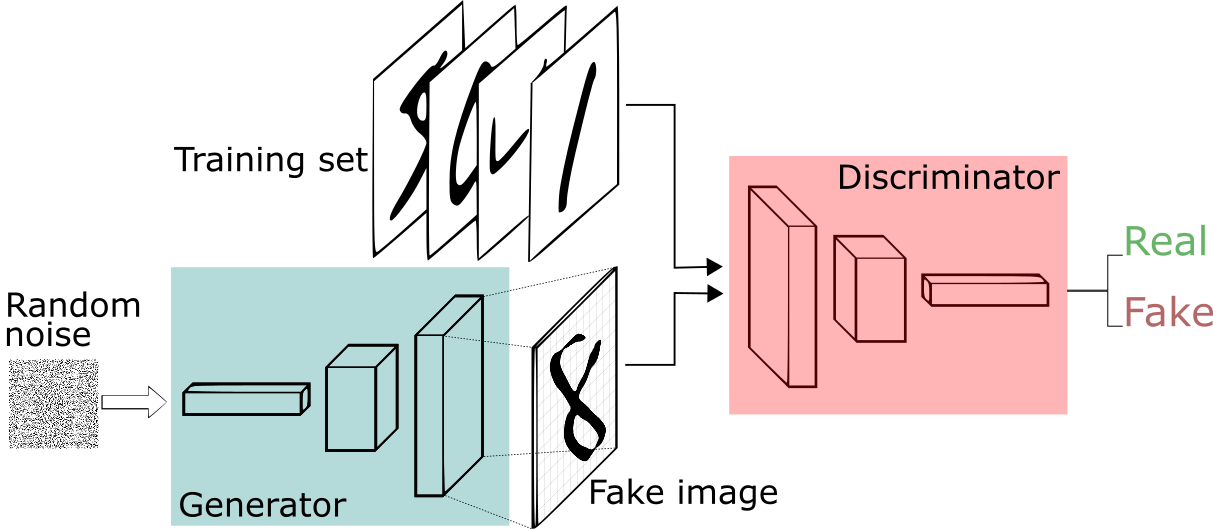

In [44]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [45]:
device = 'cuda'
batch_size=128
noise_dim=64
#optimizer parameters
lr=0.002
beta_1=0.5
beta_2=0.09

#training variables

epoch=20


# Load MNIST Dataset

In [46]:
from torchvision import datasets,transforms as T

In [47]:
train_args=T.Compose([
    T.RandomRotation((-20,+20)),
    T.ToTensor()
])

In [48]:
trainset=datasets.MNIST('MNIST/',download=True,train=True,transform=train_args)

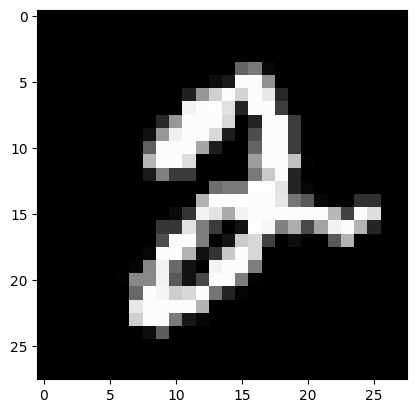

In [49]:
image,label=trainset[5]
plt.imshow(image.squeeze(),cmap='gray')

In [50]:
print("total images in train set",len(trainset))

total images in train set 60000


# Load Dataset Into Batches

In [51]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [52]:
train_loader=DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [53]:
print("Total number of batches in trainloader",len(train_loader))

Total number of batches in trainloader 469


In [54]:
dataiter=iter(train_loader)
images,_=next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [55]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

For 1 digit per image

In [56]:
def show_tensor_images(tensor_img):
    unflat_img = tensor_img.detach().cpu()
    img = unflat_img[0].squeeze()  # Select the first image and remove extra dimensions
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

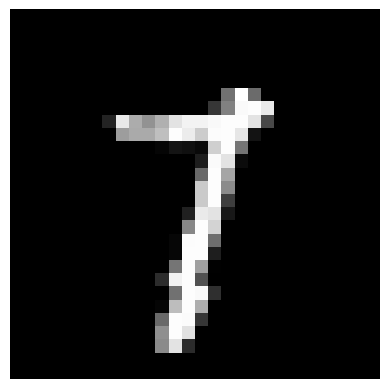

In [57]:
show_tensor_images(images)

# Create Discriminator Network

In [40]:
#In case if torch summary is not installed

!pip install torchsummary

In [15]:
from torch import nn
from torchsummary import summary

In [16]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [17]:
def get_disc_block(in_channels,out_channels,kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [18]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.block1=get_disc_block(1,16,(3,3),2)
    self.block2=get_disc_block(16,32,(5,5),2)
    self.block3=get_disc_block(32,64,(5,5),2)
    self.flatten=nn.Flatten()
    self.linear=nn.Linear(in_features=64,out_features=1)

  def forward(self,images):
    x1= self.block1(images)
    x2= self.block2(x1)
    x3= self.block3(x2)
    x4= self.flatten(x3)
    x5= self.linear(x4)
    return x5

In [19]:
D=Discriminator()
D.to(device)

summary(D,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [20]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [21]:
def get_gen_block(in_channels,out_channels,kernel_size,stride,final_block=False):
  if final_block==True:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.Tanh()
  )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [22]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()
    self.noise_dim=noise_dim
    self.block1=get_gen_block(noise_dim,256,(3,3),2)
    self.block2=get_gen_block(256,128,(4,4),1)
    self.block3=get_gen_block(128,64,(3,3),2)
    self.block4=get_gen_block(64,1,(4,4),2,True)

  def forward(self,r_noise_vec):
    x=r_noise_vec.view(-1,self.noise_dim,1,1)

    x1=self.block1(x)
    x2=self.block2(x1)
    x3=self.block3(x2)
    x4=self.block4(x3)

    return x4



In [23]:
G=Generator(noise_dim)
G.to(device)
summary(G,input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [24]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [25]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [26]:
def real_loss(disc_grad):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_grad)
  loss=criterion(disc_grad,ground_truth)
  return loss

def fake_loss(disc_grad):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_grad)
  loss=criterion(disc_grad,ground_truth)
  return loss

In [29]:
D_opt=torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))
G_opt=torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :1 | G_loss:0.723244841546138 | D_loss:0.6836413007809409


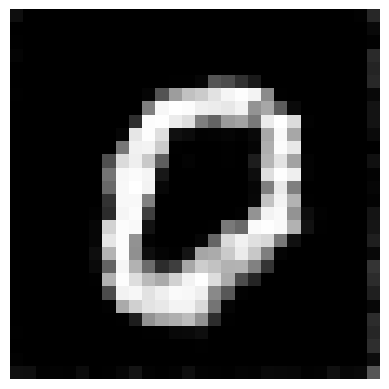

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :2 | G_loss:0.7233586523578619 | D_loss:0.6840422529655733


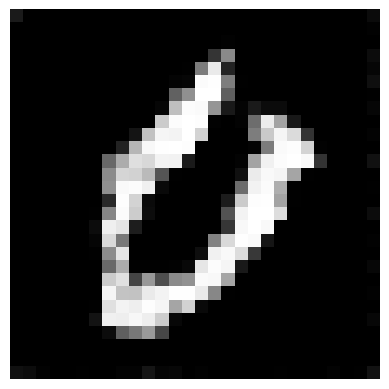

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :3 | G_loss:0.7227892194475446 | D_loss:0.6840165995839816


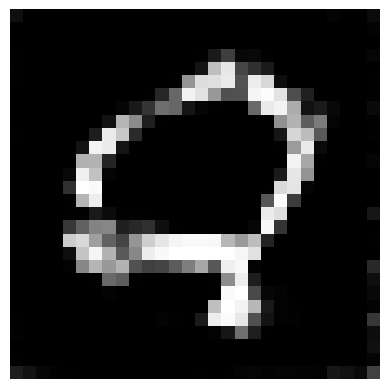

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :4 | G_loss:0.7245067965501407 | D_loss:0.6833862418304882


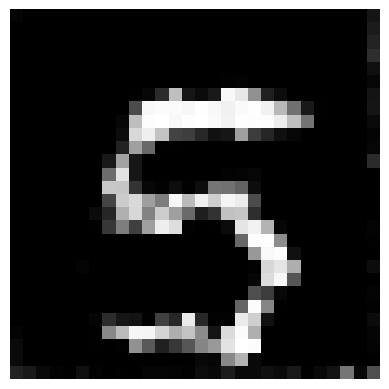

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :5 | G_loss:0.7261501967525685 | D_loss:0.6825357262513785


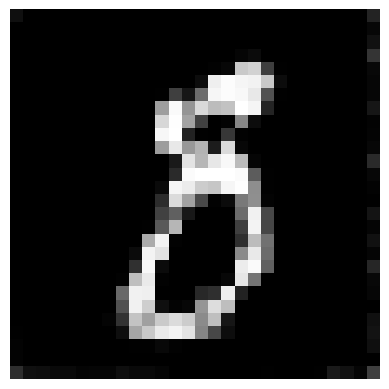

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :6 | G_loss:0.7256342546263738 | D_loss:0.6834482778109976


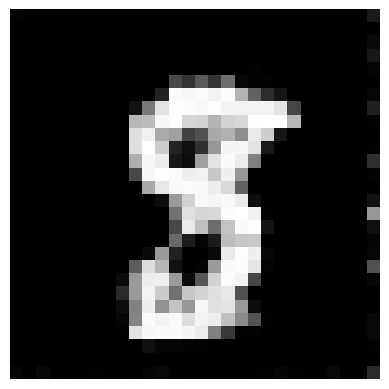

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :7 | G_loss:0.7284667841407028 | D_loss:0.6817303158835307


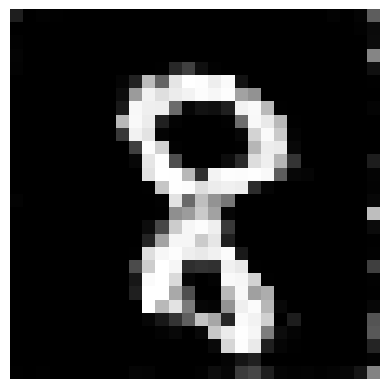

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :8 | G_loss:0.7293472227765553 | D_loss:0.6814345254826901


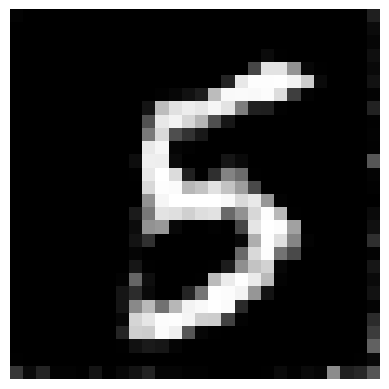

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :9 | G_loss:0.7316255957078832 | D_loss:0.6800575152134845


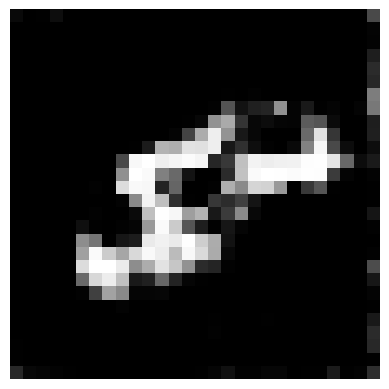

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :10 | G_loss:0.7302982498333652 | D_loss:0.6808719303308011


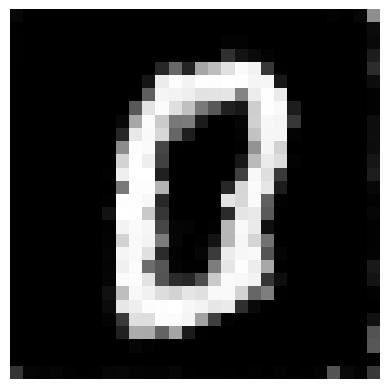

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :11 | G_loss:0.7335595009423522 | D_loss:0.6806468312928418


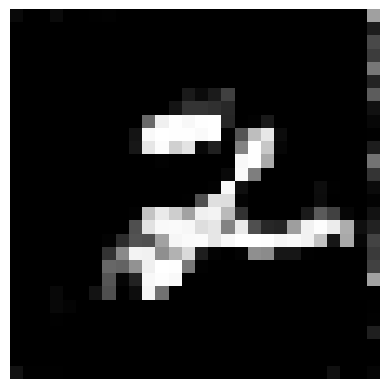

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :12 | G_loss:0.7329904232452165 | D_loss:0.679445624605679


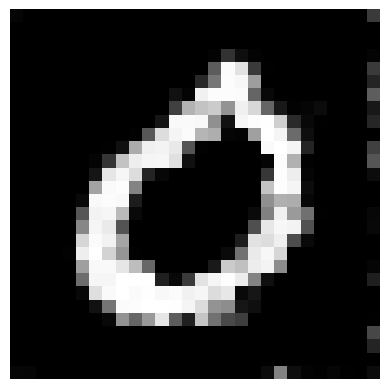

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :13 | G_loss:0.7352825701872169 | D_loss:0.6794238046034059


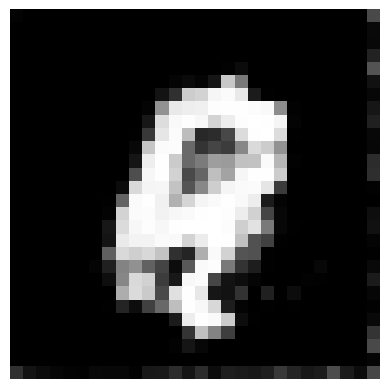

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :14 | G_loss:0.7350068499030334 | D_loss:0.6785520756168406


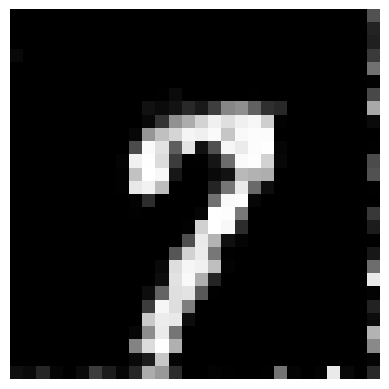

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :15 | G_loss:0.735300667504512 | D_loss:0.6790523972592628


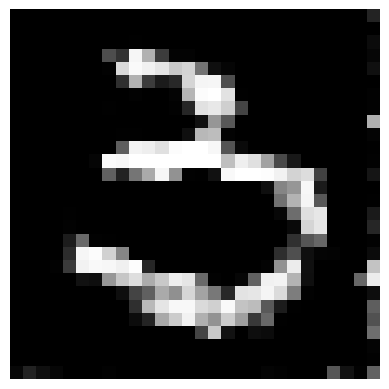

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :16 | G_loss:0.7358369698910825 | D_loss:0.6798009259868533


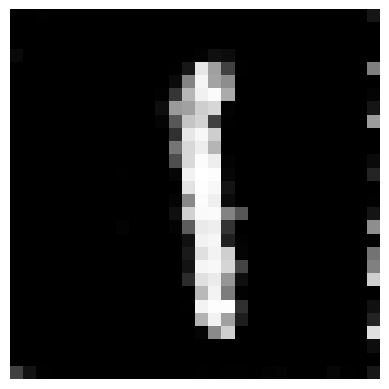

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :17 | G_loss:0.7396736026826952 | D_loss:0.6771675950682747


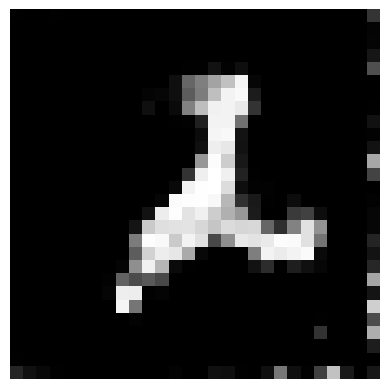

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :18 | G_loss:0.7416528204102506 | D_loss:0.6765633027182459


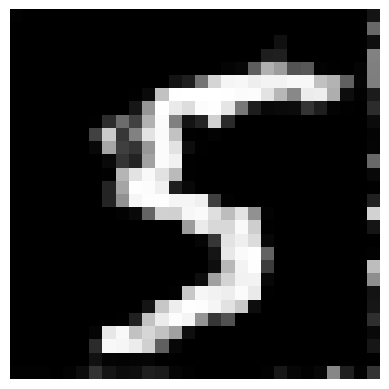

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :19 | G_loss:0.7410809346861931 | D_loss:0.6769871404176073


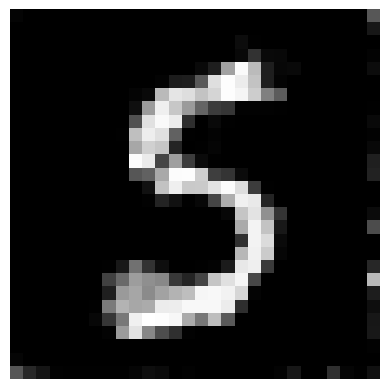

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :20 | G_loss:0.7428155620215036 | D_loss:0.6768811543358922


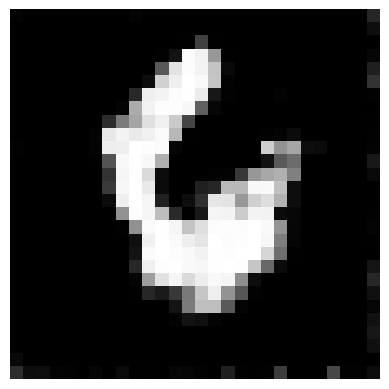

In [59]:
for i in range(epoch):
  total_d_loss=0.0
  total_g_loss=0.0

  for real_img,_ in tqdm(train_loader):
    real_img=real_img.to(device)
    noise=torch.randn(batch_size,noise_dim,device=device)

    #Find loss and update weights for D

    D_opt.zero_grad()
    fake_img=G(noise)
    D_pred=D(fake_img)
    D_fake_loss=fake_loss(D_pred)

    D_pred=D(real_img)
    D_real_loss=real_loss(D_pred)
    D_loss=(D_fake_loss+D_real_loss)/2
    total_d_loss +=D_loss.item()
    D_loss.backward()
    D_opt.step()

     #Find loss and update weights for G

    G_opt.zero_grad()
    noise=torch.randn(batch_size,noise_dim,device=device)
    fake_img=G(noise)
    D_pred=D(fake_img)
    G_loss=real_loss(D_pred)
    total_g_loss +=G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss=total_d_loss/len(train_loader)
  avg_g_loss=total_g_loss/len(train_loader)

  print("Epoch :{} | G_loss:{} | D_loss:{}".format(i+1,avg_g_loss,avg_d_loss))
  show_tensor_images(fake_img)


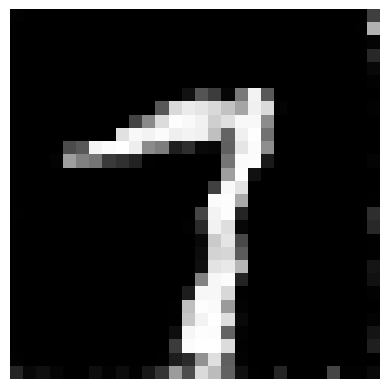

In [60]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)